In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


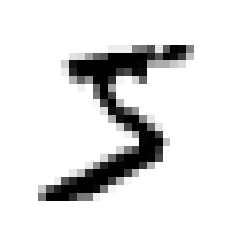

In [5]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
from sklearn.model_selection import  StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

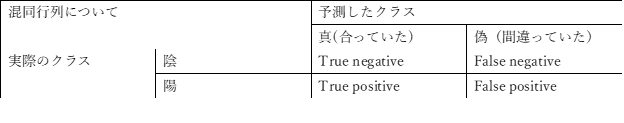

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

○適合率(precision)：陽性の予測の正解率（陽性と予測したときにどれくらい合っていたか）\
→むやみに陽性と判断すると低くなる\
○再現率(recall)・感度(sensitivity)・真陽性率(TPR: true positive rate):分類器が正しく分類した陽性インスタンスの割合（陽性だったときにどれくらい合っていたか）\
→陽性と判断しやすいほど高くなる\
➡適合率と再現率はトレードオフ！\
F1値：適合率と再現率の調和平均（harmonic mean）→適合率と再現率の両方が高くなければ上がらない\
ただ、適合率のほうが重視される場合や再現率のほうが重視される場合は適さない。


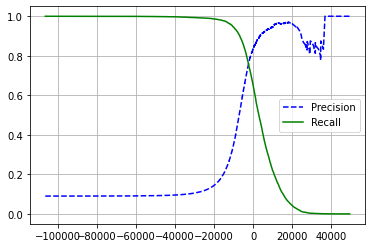

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.legend()
plt.grid()
plt.show()

In [23]:
from sklearn.metrics import precision_score, recall_score
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))

print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


ROC曲線（receiver operating characteristic：受信者動作特性曲線）：偽陽性率（FPR: false positive ratio）に対する真陽性率（TPR: true positive rate＝再現率）をプロットしたもの\
➡TPRが上がれば上がるほど、FPRも上がる（当てずっぽうにやれば間違えやすくなる）
AUC(area under the curve: 曲線の下の面積)：分類器の指標になる（面積が大きいほどすぐれている）


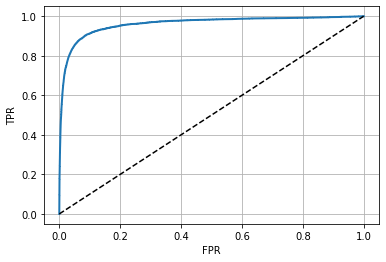

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')#'k--'は黒い点線
  plt.grid()
  plt.xlabel("FPR")
  plt.ylabel("TPR")

plot_roc_curve(fpr, tpr)
plt.show()

PR曲線とROC曲線の使い分け\
PR曲線\
・陽性クラスが珍しいとき\
・偽陰性よりも偽陽性のほうが気になるとき\
ROC曲線\
・それ以外のとき


In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

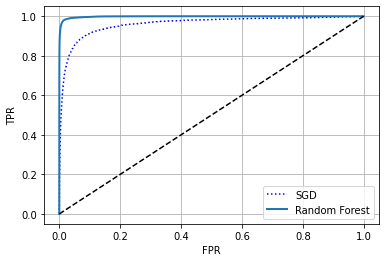

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

**3.4 多クラス分類**\
多クラス分類器（multiclass classifier)・多項分類器（multinomial classifier)

OVA法(one-versus-all)・OVR法（one-versus-rest):それぞれのクラスについて二項分類器を訓練して、分類するときには、個々の分類器の決定スコアを比較し、もっとも高いスコアを出力した分類器のクラスを選ぶ。\
（p.102 OVR法のスペル誤植）\
OVO法(one-versus-one)：数字のすべてのペアに対して二項分類器を訓練する。\
→区別しなければならない2つのクラスに属するインスタンスだけを対象として分類器を訓練できる。\
→小さな訓練セットで多数の分類器を訓練するほうが仕事が早くなる

In [35]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [28]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [29]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [30]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
len(ovr_clf.estimators_)

10

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [37]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

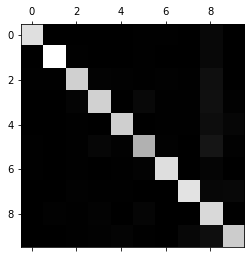

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

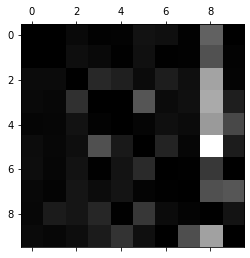

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [42]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab = X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba = X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb = X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

In [51]:
# EXTRA
import matplotlib.pyplot as plt
import matplotlib.cm
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

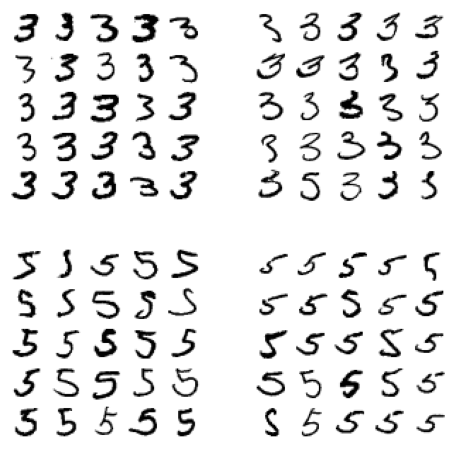

In [53]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

**多ラベル分類**

多ラベル分類(multilabel classification)：複数の2値タグを出力する分類システム

In [54]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]#二つの行ベクトルを行列にするn×2の行列になる

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

サポート：ターゲットラベルを持つインスタンスの数

In [57]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

**多出力分類**
多出力多クラス分類(multioutput-multiclass classification)/多クラス分類(multioutput classification)

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod=X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

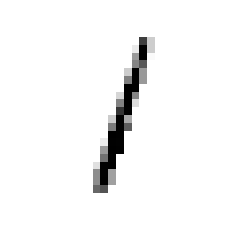

In [66]:
clean_digit = knn_clf.predict([X_test_mod[2]])
plot_digits(clean_digit)